In [1]:
from sleeper_wrapper import League
import pandas as pd
from sleeper_wrapper import Stats
from sleeper_wrapper import Players


In [2]:
lid = 656332800647081984
league = League(lid)
roster = league.get_rosters()
users = pd.DataFrame(league.get_users())
user_sub = users[['user_id', 'display_name']]  
flex = ['RB', 'WR', 'TE']
superflex = ['QB', 'RB', 'WR', 'TE']
positions = ['QB', 'RB', 'RB', 'WR', 'WR', 'TE', 'superflex', 'flex']

In [74]:
stats = Stats()
t = stats.get_all_stats(season_type='regular', season= 2020)
total_stats = pd.DataFrame.from_dict(t, orient = 'index')
total_stats.reset_index(inplace = True)
qbst = ['index', 'pass_td_40p', 'pass_cmp_40p', 'bonus_pass_yd_300', 'bonus_pass_yd_400', 'pass_yd', 'pass_td', 'pass_int',
       'rush_td', 'rush_yd']

stats_df = total_stats[qbst]
stats_df.columns = ['players', 'pass_td_40p', 'pass_cmp_40p', 'bonus_pass_yd_300', 'bonus_pass_yd_400', 
                    'pass_yd', 'pass_td', 'pass_int', 'rush_td', 'rush_yd']


In [75]:
lid = 656332800647081984
league = League(lid)
roster = league.get_rosters()
roster_df = pd.DataFrame(roster)
rdf_sub = roster_df[['owner_id', 'players']]

owner_df = rdf_sub.set_index('owner_id').players.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'players'})

stats_df.reset_index(inplace = True)

stat_sub = stats_df

ow_st_merge = pd.merge(owner_df, stat_sub, on='players', how='left')

players = Players()
player_df = pd.DataFrame.from_dict(players.get_all_players(), orient='index')
player_sub = player_df[['player_id', 'position', 'first_name', 'last_name']]
player_sub.columns = ['players', 'position', 'first_name', 'last_name']

pl_ow_st = pd.merge(ow_st_merge, player_sub, on = 'players', how = 'left')

In [78]:
users = pd.DataFrame(league.get_users())
user_sub = users[['user_id', 'display_name']]  
user_sub.columns = ['owner_id', 'display_name']

In [79]:
final = pd.merge(user_sub, pl_ow_st, on = 'owner_id', how = 'inner')

In [161]:
qb_df = final.loc[final['position'] == 'QB'][['display_name', 'first_name', 'last_name'] + qbst]
qb_df.fillna(0, inplace = True)

six_score_dict = {'pass_td_40p': 1, 'pass_cmp_40p': 0, 'bonus_pass_yd_300': 1, 'bonus_pass_yd_400': 2,'pass_yd':1/20, 
              'pass_td': 6, 'pass_int': -2, 'rush_td': 6, 'rush_yd': 1/10}

four_score_dict = {'pass_td_40p': 1, 'pass_cmp_40p': 0, 'bonus_pass_yd_300': 1, 'bonus_pass_yd_400': 2,'pass_yd':1/20, 
              'pass_td': 4, 'pass_int': -2, 'rush_td': 6, 'rush_yd': 1/10}

pyd_score_dict = {'pass_td_40p': 1, 'pass_cmp_40p': 0, 'bonus_pass_yd_300': 1, 'bonus_pass_yd_400': 2,'pass_yd':1/25, 
              'pass_td': 6, 'pass_int': -2, 'rush_td': 6, 'rush_yd': 1/10}

bonus_scoring = {'pass_td_40p': 1, 'pass_cmp_40p': 0, 'bonus_pass_yd_300': 1, 'bonus_pass_yd_400': 2}
bonus_scoring_old = {'pass_td_40p': 2, 'pass_cmp_40p': 1, 'bonus_pass_yd_300': 3, 'bonus_pass_yd_400': 4}

six_qb_score = qb_df[list(score_dict.keys())].dot(pd.Series(six_score_dict))
four_qb_score = qb_df[list(score_dict.keys())].dot(pd.Series(four_score_dict))
pyd_qb_score = qb_df[list(score_dict.keys())].dot(pd.Series(pyd_score_dict))

bonus_score = qb_df[list(bonus_scoring.keys())].dot(pd.Series(bonus_scoring))
bonus_score_old = qb_df[list(bonus_scoring_old.keys())].dot(pd.Series(bonus_scoring_old))

In [164]:
qb_df['qb_score_6p'] = six_qb_score
qb_df['qb_score_4p'] = four_qb_score
qb_df['qb_score_25yd'] = pyd_qb_score
qb_df['bonus_score'] = bonus_score
qb_df['bonus_score_old'] = bonus_score_old

In [168]:
qb_df['ratio'] = qb_df['bonus_score_old']/qb_df['qb_score_6p']

In [173]:
qb_df.sort_values('qb_score_6p', ascending = False).iloc[0:20]['ratio'].mean()

0.0726006245396716

In [177]:
qb_df['name'] = qb_df['first_name'] + ' ' + qb_df['last_name']

In [184]:
final_df = qb_df.sort_values('qb_score_6p', ascending = False)
final_df.iloc[0:10][['first_name', 'last_name', 'qb_score_6p']]

,first_name,last_name,qb_score_6p
110,Aaron,Rodgers,536.85
38,Josh,Allen,531.30
64,Patrick,Mahomes,512.80
31,Deshaun,Watson,502.55
140,Russell,Wilson,497.90
20,Kyler,Murray,486.45
113,Tom,Brady,475.25
54,Ryan,Tannehill,450.55
78,Justin,Herbert,449.20
197,Kirk,Cousins,428.85


In [183]:
final_df = qb_df.sort_values('qb_score_4p', ascending = False)
final_df.iloc[0:10][['first_name', 'last_name', 'qb_score_4p']]

,first_name,last_name,qb_score_4p
38,Josh,Allen,457.30
110,Aaron,Rodgers,440.85
64,Patrick,Mahomes,436.80
31,Deshaun,Watson,436.55
20,Kyler,Murray,434.45
140,Russell,Wilson,417.90
113,Tom,Brady,395.25
78,Justin,Herbert,387.20
54,Ryan,Tannehill,384.55
153,Lamar,Jackson,368.35


In [179]:
final_df['wr1'] = 287
final_df['wr10'] = 207
final_df['rb1'] = 336
final_df['rb10'] = 184
final_df['rb30'] = 124

OSError: [Errno 22] Invalid argument: 'passing.png'

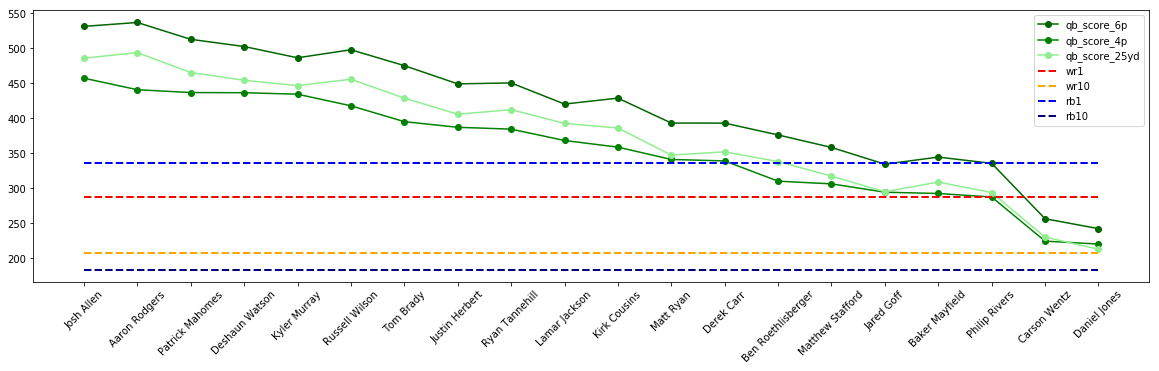

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline
plot_df = final_df.iloc[0:20]
fig,ax = plt.subplots(figsize=(20,5))
plt.xticks(rotation='45')
ax.plot(plot_df['name'],plot_df['qb_score_6p'],marker='o', color = 'darkgreen')
ax.plot(plot_df['name'],plot_df['qb_score_4p'],marker='o', color = 'green')
ax.plot(plot_df['name'],plot_df['qb_score_25yd'],marker='o', color = 'lightgreen')
ax.plot( plot_df['name'],plot_df['wr1'], color='red', linewidth=2, linestyle='dashed')
ax.plot( plot_df['name'],plot_df['wr10'], color='orange', linewidth=2, linestyle='dashed')
ax.plot( plot_df['name'],plot_df['rb1'], color='blue', linewidth=2, linestyle='dashed')
ax.plot( plot_df['name'],plot_df['rb10'], color='navy', linewidth=2, linestyle='dashed')
plt.legend()
plt.savefig('passing.png', bbox_inches='tight')

,display_name,first_name,last_name,index,pass_td_40p,pass_cmp_40p,bonus_pass_yd_300,bonus_pass_yd_400,pass_yd,pass_td,pass_int,rush_td,rush_yd,qb_score,name
110,mstanle94,Aaron,Rodgers,5172,6.0,14.0,5.0,0.0,4299.0,48.0,5.0,3.0,149.0,536.85,Aaron Rodgers
38,cthompson7,Josh,Allen,2346,2.0,8.0,6.0,2.0,4544.0,37.0,10.0,8.0,421.0,531.30,Josh Allen
64,Return0fTheMac5,Patrick,Mahomes,1554,6.0,8.0,7.0,2.0,4740.0,38.0,6.0,2.0,308.0,512.80,Patrick Mahomes
31,cthompson7,Deshaun,Watson,1538,5.0,11.0,10.0,0.0,4823.0,33.0,7.0,3.0,444.0,502.55,Deshaun Watson
140,koltclassic,Russell,Wilson,117,5.0,11.0,5.0,0.0,4212.0,40.0,13.0,2.0,513.0,497.90,Russell Wilson
20,SharpObject,Kyler,Murray,3144,4.0,14.0,2.0,1.0,3971.0,26.0,12.0,11.0,819.0,486.45,Kyler Murray
113,piconeal,Tom,Brady,323,2.0,12.0,7.0,0.0,4633.0,40.0,12.0,3.0,6.0,475.25,Tom Brady
54,Return0fTheMac5,Ryan,Tannehill,19,4.0,13.0,3.0,0.0,3819.0,33.0,7.0,7.0,266.0,450.55,Ryan Tannehill
78,Return0fTheMac5,Justin,Herbert,3971,5.0,10.0,8.0,0.0,4336.0,31.0,10.0,5.0,234.0,449.20,Justin Herbert
197,NickParks,Kirk,Cousins,77,4.0,7.0,4.0,1.0,4265.0,35.0,13.0,1.0,156.0,428.85,Kirk Cousins
